In [51]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from prophet import Prophet
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix


In [52]:
df = pd.read_csv("/Users/palaniappansubramaniam/Downloads/archive/fraudTrain.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [53]:
columns_to_delete = ['cc_num','Unnamed: 0','category','first','last','gender','city','state','zip','street','lat','long','city_pop','job','dob','trans_num','unix_time','merch_lat','merch_long',]
df = df.drop(columns=columns_to_delete)

In [54]:
print(df.columns)
df.head()

Index(['trans_date_trans_time', 'merchant', 'amt', 'is_fraud'], dtype='object')


,trans_date_trans_time,merchant,amt,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",4.97,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",107.23,0
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,220.11,0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",45.00,0
4,2019-01-01 00:03:06,fraud_Keeling-Crist,41.96,0


In [55]:
filtered_df = df.iloc[:10000]

## Custom Score and threshold between 0-1


In [56]:
class DirectAnomalyDetector:
    def __init__(self):
        pass
    
    def calculate_zscore(self, df):
        # Compute residuals
        #df['residuals'] = df['y'] - df['yhat']
        
        df['custom_score'] = np.where(df['y'] >= df['yhat'],
                      ((norm.cdf((df['y']-df['yhat'])/(df['yhat_upper']-df['yhat']))-0.5)*2),
                      ((norm.cdf((df['y']-df['yhat'])/(df['yhat']-df['yhat_lower']))-0.5)*2))
        
        # Create binary column based on threshold 
        threshold = 0.5729138813446154
        df['binary_anomaly'] = np.where(abs(df['custom_score']) > threshold, 1, 0)
        return df

    def detect_anomalies(self, df):
        # Initialize and configure the Prophet model
        model = Prophet()
        model.add_country_holidays(country_name='US')
        
        # Fit the model to the data
        model.fit(df)
        
        # Predict on the same dates as in the input data
        forecast = model.predict(df[['ds']])
        
        # Construct the result dataframe
        result_df = df.copy()
        result_df[['yhat', 'yhat_upper', 'yhat_lower']] = forecast[['yhat', 'yhat_upper', 'yhat_lower']]
        result_df['yhat_residual'] = result_df['y'] - result_df['yhat']
    
        # Calculating z-score
        result_df = self.calculate_zscore(result_df)
        
        # Determining outliers based on prediction intervals
        result_df['outliers'] = (result_df['y'] < result_df['yhat_lower']) | (result_df['y'] > result_df['yhat_upper'])  
        outlier_rate = (result_df['outliers'].mean()) * 100

        # Comparing detected anomalies with the 'is_fraud' column
        result_df['compare'] = np.where(
           (result_df['binary_anomaly'] == 1) & (result_df['is_fraud'] == 1), True, False)
        
        print("Value counts in 'compare':")
        print(result_df['compare'].value_counts())

        # Print the metrics
        print("Outlier Rate =", outlier_rate)
    
        return result_df[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower', 'custom_score', 'outliers','binary_anomaly','is_fraud','compare']], outlier_rate

# Importing data
df = filtered_df
df = filtered_df[['trans_date_trans_time','amt','is_fraud']]
df = df.rename(columns = {'amt':'y'})
df.rename(columns = {'trans_date_trans_time':'ds'}, inplace = True)
datetime_format = '%Y-%m-%d %H:%M:%S'
df['ds'] = pd.to_datetime(df['ds'], format=datetime_format)

# Using the DirectAnomalyDetector class
direct_anomaly_detector = DirectAnomalyDetector()
final_df, outlier_rate_direct = direct_anomaly_detector.detect_anomalies(df)
final_df.head()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Value counts in 'compare':
False    9963
True       37
Name: compare, dtype: int64
Outlier Rate = 3.94


,ds,y,yhat,yhat_upper,yhat_lower,custom_score,outliers,binary_anomaly,is_fraud,compare
0,2019-01-01 00:00:18,4.97,78.862468,216.221976,-64.958757,-0.392594,False,0,0,False
1,2019-01-01 00:00:44,107.23,78.860481,227.881996,-56.906727,0.150982,False,0,0,False
2,2019-01-01 00:00:51,220.11,78.859946,220.583551,-51.961319,0.681070,False,1,0,False
3,2019-01-01 00:01:16,45.00,78.858039,221.353778,-63.944494,-0.187418,False,0,0,False
4,2019-01-01 00:03:06,41.96,78.849702,225.213498,-61.084395,-0.207929,False,0,0,False


In [9]:
count_ones = df['is_fraud'].iloc[:10000].sum()
print(count_ones)

47


## Traditional Z score with threshold range 0-1

In [57]:
class DirectAnomalyDetector:
    def __init__(self):
        pass
    
    def calculate_zscore(self, df):
        # Compute residuals
        df['residuals'] = df['y'] - df['yhat']
        
        # Compute traditional z-score
        df['zscore'] = (df['residuals'] - df['residuals'].mean()) / df['residuals'].std()
        
        # Create binary column based on threshold 
        threshold = 0.97
        df['binary_anomaly'] = np.where(abs(df['zscore']) > threshold, 1, 0)
        return df

    def detect_anomalies(self, df):
        # Initialize and configure the Prophet model
        model = Prophet()
        model.add_country_holidays(country_name='US')
        
        # Fit the model to the data
        model.fit(df)
        
        # Predict on the same dates as in the input data
        forecast = model.predict(df[['ds']])
        
        # Construct the result dataframe
        result_df = df.copy()
        result_df[['yhat', 'yhat_upper', 'yhat_lower']] = forecast[['yhat', 'yhat_upper', 'yhat_lower']]
        result_df['yhat_residual'] = result_df['y'] - result_df['yhat']
    
        # Calculating z-score
        result_df = self.calculate_zscore(result_df)
        
        # Determining outliers based on prediction intervals
        result_df['outliers'] = (result_df['y'] < result_df['yhat_lower']) | (result_df['y'] > result_df['yhat_upper'])  
        outlier_rate = (result_df['outliers'].mean()) * 100

        # Comparing detected anomalies with the 'is_fraud' column
        result_df['compare'] = np.where(
           (result_df['binary_anomaly'] == 1) & (result_df['is_fraud'] == 1), True, False)
        
        
        print("Value counts in 'compare':")
        print(result_df['compare'].value_counts())
        

        # Print the metrics
        print("Outlier Rate =", outlier_rate)
    
        return result_df[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower', 'zscore', 'outliers','binary_anomaly','is_fraud','compare']], outlier_rate

# Importing data
df = filtered_df
df = filtered_df[['trans_date_trans_time','amt','is_fraud']]
df = df.rename(columns = {'amt':'y'})
df.rename(columns = {'trans_date_trans_time':'ds'}, inplace = True)
datetime_format = '%Y-%m-%d %H:%M:%S'
df['ds'] = pd.to_datetime(df['ds'], format=datetime_format)

# Using the DirectAnomalyDetector class
direct_anomaly_detector = DirectAnomalyDetector()
final_df, outlier_rate_direct = direct_anomaly_detector.detect_anomalies(df)
final_df.head()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Value counts in 'compare':
False    9963
True       37
Name: compare, dtype: int64
Outlier Rate = 3.92


,ds,y,yhat,yhat_upper,yhat_lower,zscore,outliers,binary_anomaly,is_fraud,compare
0,2019-01-01 00:00:18,4.97,78.862468,221.711937,-61.433336,-0.664776,False,0,0,False
1,2019-01-01 00:00:44,107.23,78.860481,230.374886,-58.733466,0.255273,False,0,0,False
2,2019-01-01 00:00:51,220.11,78.859946,214.724494,-57.549950,1.270856,True,1,0,False
3,2019-01-01 00:01:16,45.00,78.858039,228.877071,-51.206830,-0.304587,False,0,0,False
4,2019-01-01 00:03:06,41.96,78.849702,217.155049,-62.877531,-0.331863,False,0,0,False


## Prophet with Regressors and threshold 0-100

In [58]:
class DirectAnomalyDetector:
    def __init__(self):
        pass
    
    def calculate_zscore(self, df):
        # Compute residuals
        df['residuals'] = df['y'] - df['yhat']
        
        # Compute traditional z-score
        df['zscore'] = (df['residuals'] - df['residuals'].mean()) / df['residuals'].std()
        
        # Create binary column based on threshold 
        threshold_percentage = 97 
        threshold = threshold_percentage / 100.0  # Convert it back to a fraction for comparison
        df['binary_anomaly'] = np.where(abs(df['zscore']) > threshold, 1, 0)
        return df
   
    def detect_anomalies(self, df):
        
        # Creating temporal features
        df['day_of_week'] = df['ds'].dt.dayofweek
        df['hour_of_day'] = df['ds'].dt.hour
        
        # Creating transaction features with handling NaN values
        df['rolling_mean_10'] = df['y'].rolling(window=10).mean()
        df['rolling_std_10'] = df['y'].rolling(window=10).std()

        # Filling NaN values with the mean of the respective columns
        df['rolling_mean_10'].fillna(df['rolling_mean_10'].mean(), inplace=True)
        df['rolling_std_10'].fillna(df['rolling_std_10'].mean(), inplace=True)


        # Initialize and configure the Prophet model
        model = Prophet(changepoint_prior_scale=0.2, yearly_seasonality=True)
        model.add_regressor('day_of_week')
        model.add_regressor('hour_of_day')
        model.add_regressor('rolling_mean_10')
        model.add_regressor('rolling_std_10')
        model.add_country_holidays(country_name='US')
        model.add_seasonality(name='daily', period=30.5, fourier_order=8)
        
        # Fit the model to the data
        model.fit(df)
        
        # Predict on the same dates as in the input data
        forecast = model.predict(df[['ds', 'day_of_week', 'hour_of_day', 'rolling_mean_10', 'rolling_std_10']])

        
        # Construct the result dataframe
        result_df = df.copy()
        result_df[['yhat', 'yhat_upper', 'yhat_lower']] = forecast[['yhat', 'yhat_upper', 'yhat_lower']]
        result_df['yhat_residual'] = result_df['y'] - result_df['yhat']
    
        # Calculating z-score
        result_df = self.calculate_zscore(result_df)
        
        # Determining outliers based on prediction intervals
        result_df['outliers'] = (result_df['y'] < result_df['yhat_lower']) | (result_df['y'] > result_df['yhat_upper'])  
        outlier_rate = (result_df['outliers'].mean()) * 100

        # Comparing detected anomalies with the 'is_fraud' column
        result_df['compare'] = np.where(
           (result_df['binary_anomaly'] == 1) & (result_df['is_fraud'] == 1), True, False)
        
        
        print("Value counts in 'compare':")
        print(result_df['compare'].value_counts())
        

        # Print the metrics
        print("Outlier Rate =", outlier_rate)
    
        return result_df[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower', 'zscore', 'outliers','binary_anomaly','is_fraud','compare']], outlier_rate

# Importing data
df = filtered_df
df = filtered_df[['trans_date_trans_time','amt','is_fraud']]
df = df.rename(columns = {'amt':'y'})
df.rename(columns = {'trans_date_trans_time':'ds'}, inplace = True)
datetime_format = '%Y-%m-%d %H:%M:%S'
df['ds'] = pd.to_datetime(df['ds'], format=datetime_format)

# Extract day of the week from the 'ds' column and create a new column 'day_of_week'
df['day_of_week'] = df['ds'].dt.dayofweek

# Using the DirectAnomalyDetector class
direct_anomaly_detector = DirectAnomalyDetector()
final_df, outlier_rate_direct = direct_anomaly_detector.detect_anomalies(df)
final_df.head()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Value counts in 'compare':
False    9960
True       40
Name: compare, dtype: int64
Outlier Rate = 5.84


,ds,y,yhat,yhat_upper,yhat_lower,zscore,outliers,binary_anomaly,is_fraud,compare
0,2019-01-01 00:00:18,4.97,68.685400,204.534957,-66.936774,-0.604009,False,0,0,False
1,2019-01-01 00:00:44,107.23,68.685995,188.350264,-61.799717,0.365360,False,0,0,False
2,2019-01-01 00:00:51,220.11,68.686155,203.198874,-69.631618,1.435406,True,1,0,False
3,2019-01-01 00:01:16,45.00,68.686726,206.812540,-82.344945,-0.224557,False,0,0,False
4,2019-01-01 00:03:06,41.96,68.689230,206.911276,-64.604002,-0.253398,False,0,0,False


In [59]:
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from prophet import Prophet
import pandas as pd

In [60]:
from sklearn.model_selection import train_test_split


## Testing and training the model

In [62]:
class DirectAnomalyDetector:
    def __init__(self):
        pass
    
    def calculate_zscore(self, df):
    # Compute residuals
        df['residuals'] = df['y'] - df['yhat']

        df['custom_score'] = np.where(df['y'] >= df['yhat'],
                      ((norm.cdf((df['y']-df['yhat'])/(df['yhat_upper']-df['yhat']))-0.5)*2),
                      ((norm.cdf((df['y']-df['yhat'])/(df['yhat']-df['yhat_lower']))-0.5)*2))

        # Create binary column based on threshold 
        threshold = 0.67
        df['binary_anomaly'] = np.where(abs(df['custom_score']) > threshold, 1, 0)
    
        # Determining outliers based on prediction intervals
        df['outliers'] = (df['y'] < df['yhat_lower']) | (df['y'] > df['yhat_upper'])  
        outlier_rate = (df['outliers'].mean()) * 100

        return df, outlier_rate


    def prophet_forecasting(self, train_df, df):
        # Initialize and configure the Prophet model
        model = Prophet()
        model.add_country_holidays(country_name='US')
        
        # Fit the model to the data
        model.fit(train_df)
        
        # Predict on the same dates as in the input data
        forecast = model.predict(df[['ds']])
        
        # Construct the result dataframe
        result_df = df.copy()
        result_df = result_df.merge(forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on='ds', how='left')
        result_df['yhat_residual'] = result_df['y'] - result_df['yhat']
        
        return result_df

    def detect_anomalies(self, df):
        # Getting the forecast using the prophet_forecasting method
        result_df = self.prophet_forecasting(df, df)

        # Calculating z-score
        result_df, outlier_rate = self.calculate_zscore(result_df)
    
        # Comparing detected anomalies with the 'is_fraud' column
        result_df['compare'] = np.where(
           (result_df['binary_anomaly'] == 1) & (result_df['is_fraud'] == 1), True, False)
    
        print("Value counts in 'compare':")
        print(result_df['compare'].value_counts())

        # Print the metrics
        print("Outlier Rate =", outlier_rate)

        return result_df[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower', 'custom_score', 'outliers','binary_anomaly','is_fraud','compare']], outlier_rate
        

# Importing data
df = filtered_df
df = df.rename(columns = {'amt':'y'})
df.rename(columns = {'trans_date_trans_time':'ds'}, inplace = True)
datetime_format = '%Y-%m-%d %H:%M:%S'
df['ds'] = pd.to_datetime(df['ds'], format=datetime_format)

# Split the data into training and testing sets (70-30 split)
train_size = int(0.7 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Using the DirectAnomalyDetector class to train on the training set
direct_anomaly_detector = DirectAnomalyDetector()
final_train_df, outlier_rate_direct_train = direct_anomaly_detector.detect_anomalies(train_df)

# Using the trained Prophet model to predict on the test set
final_test_df = direct_anomaly_detector.prophet_forecasting(train_df, test_df)
final_test_df, outlier_rate_direct_test = direct_anomaly_detector.calculate_zscore(final_test_df)

# Merging the forecasted data with the test set to ensure only the test dates are considered for MSE
test_df = test_df.merge(final_test_df[['ds', 'yhat']], on='ds', how='inner')


# Display the first few rows of the final test dataframe
print(final_test_df.head())


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


Value counts in 'compare':
False    7122
True       28
Name: compare, dtype: int64
Outlier Rate = 3.5804195804195804


INFO:cmdstanpy:finish chain 1


                   ds                              merchant       y  is_fraud  \
0 2019-01-05 15:19:04                    fraud_Kassulke PLC  624.31         0   
1 2019-01-05 15:19:46                     fraud_Dare-Gibson   15.54         0   
2 2019-01-05 15:20:34  fraud_Schroeder, Wolff and Hermiston  799.50         0   
3 2019-01-05 15:22:17                        fraud_Howe PLC   68.55         0   
4 2019-01-05 15:22:19                    fraud_Waelchi-Wolf   71.25         0   

        yhat  yhat_upper  yhat_lower  yhat_residual   residuals  custom_score  \
0  63.539006  204.802473  -85.653336     560.770994  560.770994      0.999928   
1  63.607222  206.450647  -79.291986     -48.067222  -48.067222     -0.263409   
2  63.684907  212.523286  -88.736155     735.815093  735.815093      0.999999   
3  63.850546  207.793557  -83.803587       4.699454    4.699454      0.026045   
4  63.853748  193.709316  -88.420044       7.396252    7.396252      0.045421   

   binary_anomaly  outlier

## Test and Train type 2

In [63]:
from prophet import Prophet
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import pandas as pd
import numpy as np

class DirectAnomalyDetector:
    def __init__(self):
        pass
    
    def calculate_zscore(self, df):
        # Compute residuals
        df['residuals'] = df['y'] - df['yhat']
        
        # Calculate the z-score
        df['zscore'] = (df['residuals'] - df['residuals'].mean()) / df['residuals'].std()
        
        # Create a binary anomaly column based on a threshold (e.g., 2.5 for 2.5 standard deviations)
        threshold = .67
        #threshold = threshold_percentage / 100.0        
        df['binary_anomaly'] = np.where(abs(df['zscore']) > threshold, 1, 0)
        
        return df

    def detect_anomalies(self, df):
        # Split the data into training and testing sets
        train, test = train_test_split(df, test_size=0.3, shuffle=False)

        # Initialize the Prophet model
        model = Prophet()
        
        # Fit the model using the training data
        model.fit(train[['ds', 'y']])
        
        # Predict on the test data
        forecast = model.predict(test[['ds']])
        
        # Merge the test data with the forecast data
        result_df = pd.merge(test, forecast, on='ds', how='left')
        
        # Calculating z-score
        result_df = self.calculate_zscore(result_df)
        
        # Compare detected anomalies with the 'is_fraud' column
        result_df['compare'] = np.where((result_df['binary_anomaly'] == 1) & (result_df['is_fraud'] == 1), True, False)
        
        print("Value counts in 'compare':")
        print(result_df['compare'].value_counts())
    
        return result_df[['ds', 'y', 'yhat', 'zscore', 'binary_anomaly', 'is_fraud', 'compare']]

# Importing data
df = filtered_df
df = df[['trans_date_trans_time', 'amt', 'is_fraud']]
df = df.rename(columns={'amt':'y', 'trans_date_trans_time':'ds'})
df['ds'] = pd.to_datetime(df['ds'])

# Using the DirectAnomalyDetector class
direct_anomaly_detector = DirectAnomalyDetector()
final_df = direct_anomaly_detector.detect_anomalies(df)
final_df.head()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Value counts in 'compare':
False    3051
True       11
Name: compare, dtype: int64


,ds,y,yhat,zscore,binary_anomaly,is_fraud,compare
0,2019-01-05 15:19:04,624.31,62.439289,5.386268,1,0,False
1,2019-01-05 15:19:46,15.54,62.502663,-0.553074,0,0,False
2,2019-01-05 15:20:34,799.50,62.574833,7.093974,1,0,False
3,2019-01-05 15:22:17,68.55,62.728712,-0.038152,0,0,False
4,2019-01-05 15:22:19,71.25,62.731686,-0.011841,0,0,False


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


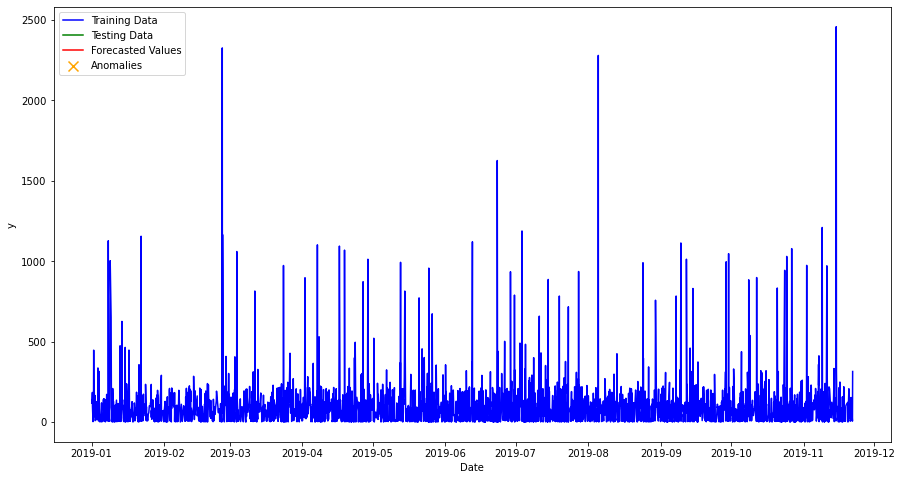

In [44]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split your data into training and testing sets
train, test = train_test_split(df, test_size=0.4, shuffle=False)

# Initialize and configure the Prophet model
model = Prophet()
model.add_country_holidays(country_name='US')

# Fit the model to the training data
model.fit(train)

# Predict on the test data
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

# Merge the forecast with the test data to create a result dataframe
test = pd.merge(test, forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']], on='ds', how='inner')

# Identify the anomalies in the result dataframe
threshold = 0.6729138813446154  # Adjust this value as needed
test['custom_score'] = np.where(test['y'] >= test['yhat'],
                                ((norm.cdf((test['y']-test['yhat'])/(test['yhat_upper']-test['yhat']))-0.5)*2),
                                ((norm.cdf((test['y']-test['yhat'])/(test['yhat']-test['yhat_lower']))-0.5)*2))
test['binary_anomaly'] = np.where(abs(test['custom_score']) > threshold, 1, 0)

# Plotting the results
plt.figure(figsize=(15, 8))

# Plot the training data
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test['ds'], test['y'], label='Testing Data', color='green')

# Plot the forecasted values
plt.plot(test['ds'], test['yhat'], label='Forecasted Values', color='red')

# Highlight the anomalies in the testing data
anomalies = test[test['binary_anomaly'] == 1]
plt.scatter(anomalies['ds'], anomalies['y'], label='Anomalies', color='orange', marker='x', s=100)

# Label the axes
plt.xlabel('Date')
plt.ylabel('y')

# Display the legend
plt.legend()

# Display the plot
plt.show()


In [28]:
print(df['y'].isnull().sum())  # This will print the number of NaN values in the 'y' column


0


In [29]:
print(train['y'].head())  # This will print the first 5 values of the 'y' column in the train set
print(test['y'].head())   # This will print the first 5 values of the 'y' column in the test set


0    0.496714
1    0.358450
2    1.006138
3    2.529168
4    2.295015
Name: y, dtype: float64
877    2.407560
878    2.391137
879    3.579531
880    6.106463
881    5.575594
Name: y, dtype: float64


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


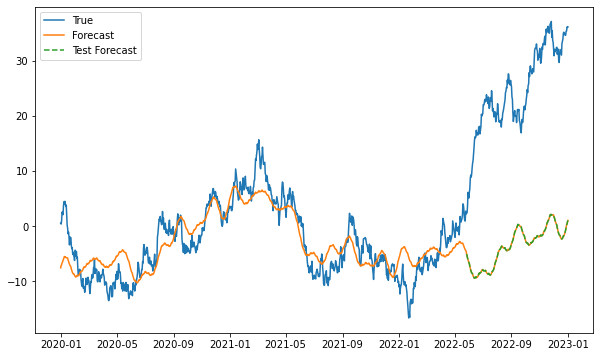

In [25]:
from prophet import Prophet
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Step 1: Generate synthetic time series data
np.random.seed(42)
ds = pd.date_range('2020-01-01', '2023-01-01', freq='D')
y = np.cumsum(np.random.randn(len(ds)))
data = pd.DataFrame({'ds': ds, 'y': y})

# Step 2: Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.2, shuffle=False)

# Step 3: Train a Prophet model on the training data
model = Prophet()
model.fit(train)

# Step 4: Create a future dataframe including dates from the testing set
future = model.make_future_dataframe(periods=len(test))

# Step 5: Forecast the future dataframe
forecast = model.predict(future)

# Step 6: Evaluate the forecast (you can use any metric you prefer here, this is just a simple visualization)
test_forecast = forecast.iloc[-len(test):]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(data['ds'], data['y'], label='True')
plt.plot(data['ds'], forecast['yhat'], label='Forecast')
plt.plot(test['ds'], test_forecast['yhat'], label='Test Forecast', linestyle='dashed')
plt.legend()
plt.show()


In [27]:
# Calculate Precision and Recall
true_positives = final_df[(final_df['binary_anomaly'] == 1) & (final_df['is_fraud'] == 1)].shape[0]
false_positives = final_df[(final_df['binary_anomaly'] == 1) & (final_df['is_fraud'] == 0)].shape[0]
false_negatives = final_df[(final_df['binary_anomaly'] == 0) & (final_df['is_fraud'] == 1)].shape[0]

if (true_positives + false_positives) != 0:
    precision = true_positives / (true_positives + false_positives)
else:
    precision = 0.0

if (true_positives + false_negatives) != 0:
    recall = true_positives / (true_positives + false_negatives)
else:
    recall = 0.0

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.391304347826087
Recall: 0.9278350515463918


In [28]:
# Assuming you have a 'is_fraud' column for ground truth labels
y_true = final_df['is_fraud']

# Assuming you have a 'binary_anomaly' column for model predictions
y_pred = final_df['binary_anomaly']

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()

print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)


True Positives (TP): 90
True Negatives (TN): 5902
False Positives (FP): 140
False Negatives (FN): 7


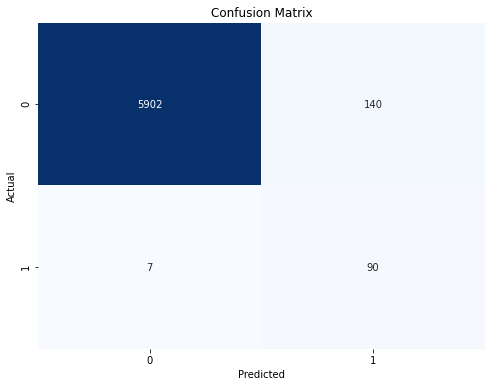

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a 'is_fraud' column for ground truth labels
y_true = final_df['is_fraud']

# Assuming you have a 'binary_anomaly' column for model predictions
y_pred = final_df['binary_anomaly']

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


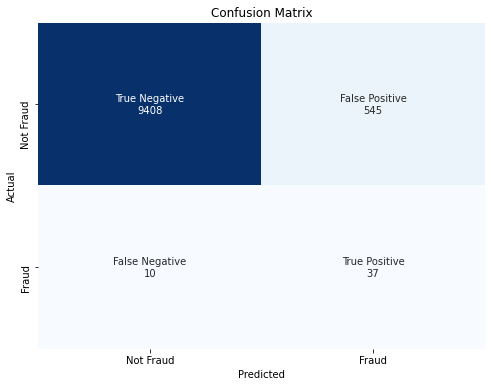

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a 'is_fraud' column for ground truth labels
y_true = final_df['is_fraud']

# Assuming you have a 'binary_anomaly' column for model predictions
y_pred = final_df['binary_anomaly']

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Get the individual counts
tn, fp, fn, tp = conf_matrix.ravel()

# Create labels with counts
labels = [[f"True Negative\n{tn}", f"False Positive\n{fp}"],
          [f"False Negative\n{fn}", f"True Positive\n{tp}"]]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', cbar=False, xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:
[[5902  140]
 [   7   90]]
Precision: 0.39
Recall: 0.93
F1 Score: 0.55


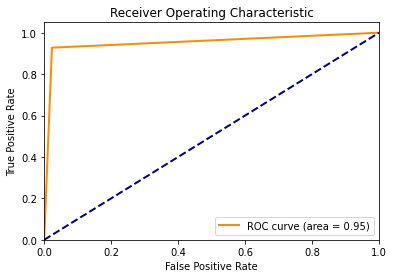

In [31]:
# Get the 'is_fraud' and 'binary_anomaly' columns to calculate metrics
y_true = final_df['is_fraud']
y_pred = final_df['binary_anomaly']

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [35]:
# Assuming you have a DataFrame named 'final_df' containing the 'binary_anomaly' and 'is_fraud' columns

# Filter the DataFrame to include only rows where 'is_fraud' is 1
fraudulent_data = final_df[final_df['is_fraud'] == 1]

# Find the minimum and maximum z-scores in the 'zscore' column for the filtered data
min_custom_score_fraud = fraudulent_data['custom_score'].min()
max_custom_score_fraud = fraudulent_data['custom_score'].max()

# Print the range of z-scores
print(f"Range of z-scores flagged as fraud: {min_custom_score_fraud} to {max_custom_score_fraud}")


Range of z-scores flagged as fraud: -0.37659122632607533 to 0.9999999996029987


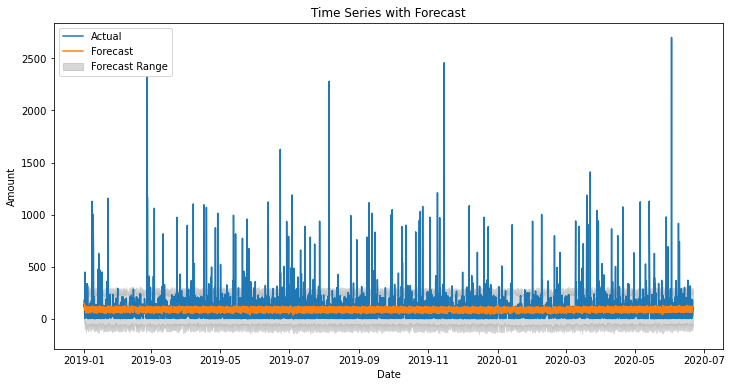

In [36]:
import matplotlib.pyplot as plt

# Plotting Time Series with Forecast
plt.figure(figsize=(12, 6))
plt.plot(final_df['ds'], final_df['y'], label='Actual')
plt.plot(final_df['ds'], final_df['yhat'], label='Forecast')
plt.fill_between(final_df['ds'], final_df['yhat_lower'], final_df['yhat_upper'], color='gray', alpha=0.3, label='Forecast Range')
plt.title('Time Series with Forecast')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


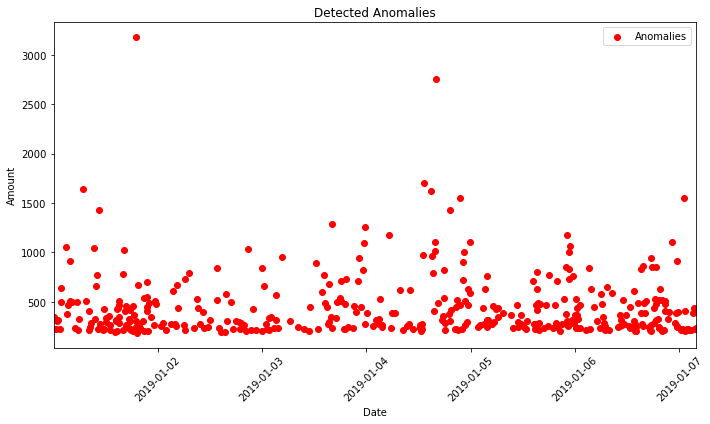

In [48]:
import matplotlib.pyplot as plt

# Plotting only the detected anomaly points with dynamic x-axis
def plot_anomalies_dynamic_x(anomaly_df):
    plt.figure(figsize=(10, 6))
    
    plt.scatter(anomaly_df['ds'], anomaly_df['y'], color='red', label='Anomalies')
    
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.title('Detected Anomalies')
    plt.legend()
    
    # Set the x-axis limits dynamically based on the min and max dates
    plt.xlim(anomaly_df['ds'].min(), anomaly_df['ds'].max())
    
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()

# Filter only the rows with detected anomalies
anomalies_df = final_df[final_df['outliers']]

# Call the plot_anomalies_dynamic_x function with the anomalies_df DataFrame
plot_anomalies_dynamic_x(anomalies_df)


In [49]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Plotting function with interactive date range selection
def plot_anomalies_dynamic_range(df, start_date, end_date):
    selected_data = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(selected_data['ds'], selected_data['y'], label='Actual')
    plt.plot(selected_data['ds'], selected_data['yhat'], label='Forecast')
    plt.fill_between(selected_data['ds'], selected_data['yhat_lower'], selected_data['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    
    anomaly_points = selected_data[selected_data['outliers']]
    plt.scatter(anomaly_points['ds'], anomaly_points['y'], color='red', label='Anomalies')
    
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.title('Time Series with Anomalies')
    plt.legend()
    
    # Set the x-axis limits based on the selected date range
    plt.xlim(start_date, end_date)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Define the date range widgets
start_date_widget = widgets.DatePicker(
    description='Start Date:',
    value=final_df['ds'].min()
)
end_date_widget = widgets.DatePicker(
    description='End Date:',
    value=final_df['ds'].max()
)

# Create the interactive plot using the interact decorator
@interact(start_date=start_date_widget, end_date=end_date_widget)
def interactive_plot(start_date, end_date):
    plot_anomalies_dynamic_range(final_df, start_date, end_date)


interactive(children=(DatePicker(value=Timestamp('2019-01-01 00:00:18'), description='Start Date:'), DatePicke…

In [ ]:
# Calculate Residuals
final_df['residuals'] = final_df['y'] - final_df['yhat']

# Residual Plot
plt.figure(figsize=(12, 6))
plt.plot(final_df['ds'], final_df['residuals'], marker='o', linestyle='None')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Line')
plt.title('Residual Plot')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()



In [ ]:
# Calculate Error Metrics
final_df['mae'] = np.abs(final_df['y'] - final_df['yhat'])
final_df['rmse'] = np.sqrt((final_df['y'] - final_df['yhat'])**2)
final_df['mape'] = np.abs((final_df['y'] - final_df['yhat']) / final_df['y']) * 100

# Error Metrics Comparison
plt.figure(figsize=(12, 6))
plt.plot(final_df['ds'], final_df['mae'], label='MAE')
plt.plot(final_df['ds'], final_df['rmse'], label='RMSE')
plt.plot(final_df['ds'], final_df['mape'], label='MAPE')
plt.title('Error Metrics Comparison')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()


In [50]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact

# Plotting function with interactive date range selection
def plot_anomalies_dynamic_range(df, start_date, end_date):
    selected_data = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(selected_data['ds'], selected_data['y'], label='Actual')
    plt.plot(selected_data['ds'], selected_data['yhat'], label='Forecast')
    plt.fill_between(selected_data['ds'], selected_data['yhat_lower'], selected_data['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    
    anomaly_points = selected_data[selected_data['outliers']]
    plt.scatter(anomaly_points['ds'], anomaly_points['y'], color='red', label='Anomalies')
    
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.title('Time Series with Anomalies')
    plt.legend()
    
    # Set the x-axis limits based on the selected date range
    plt.xlim(start_date, end_date)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Define the predefined date range buttons
one_month_button = widgets.Button(description='1 Month')
three_months_button = widgets.Button(description='3 Months')
six_months_button = widgets.Button(description='6 Months')
one_year_button = widgets.Button(description='1 Year')

# Callback functions for the predefined date range buttons
def on_one_month_button_clicked(b):
    end_date = final_df['ds'].max()
    start_date = end_date - pd.DateOffset(months=1)
    start_date_widget.value = start_date
    end_date_widget.value = end_date

def on_three_months_button_clicked(b):
    end_date = final_df['ds'].max()
    start_date = end_date - pd.DateOffset(months=3)
    start_date_widget.value = start_date
    end_date_widget.value = end_date

def on_six_months_button_clicked(b):
    end_date = final_df['ds'].max()
    start_date = end_date - pd.DateOffset(months=6)
    start_date_widget.value = start_date
    end_date_widget.value = end_date

def on_one_year_button_clicked(b):
    end_date = final_df['ds'].max()
    start_date = end_date - pd.DateOffset(years=1)
    start_date_widget.value = start_date
    end_date_widget.value = end_date

# Attach the button click event handlers
one_month_button.on_click(on_one_month_button_clicked)
three_months_button.on_click(on_three_months_button_clicked)
six_months_button.on_click(on_six_months_button_clicked)
one_year_button.on_click(on_one_year_button_clicked)

# Plotting function with interactive date range selection using Plotly
def plot_anomalies_dynamic_range(df, start_date, end_date):
    selected_data = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=selected_data['ds'], y=selected_data['y'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=selected_data['ds'], y=selected_data['yhat'], mode='lines', name='Forecast'))
    fig.add_trace(go.Scatter(x=selected_data['ds'], y=selected_data['yhat_upper'], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), name='Confidence Interval'))
    fig.add_trace(go.Scatter(x=selected_data['ds'], y=selected_data['yhat_lower'], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), name='Confidence Interval'))
    fig.add_trace(go.Scatter(x=selected_data[selected_data['outliers']]['ds'], y=selected_data[selected_data['outliers']]['y'], mode='markers', marker=dict(color='red'), name='Anomalies'))

    fig.update_layout(title='Time Series with Anomalies',
                      xaxis_title='Date',
                      yaxis_title='Amount')

    fig.show()

# Define the date range widgets
start_date_widget = widgets.DatePicker(
    description='Start Date:',
    value=final_df['ds'].min()
)
end_date_widget = widgets.DatePicker(
    description='End Date:',
    value=final_df['ds'].max()
)
# Define the interactive plot using the interact decorator
@interact(start_date=start_date_widget, end_date=end_date_widget)
def interactive_plot(start_date, end_date):
    plot_anomalies_dynamic_range(final_df, start_date, end_date)


interactive(children=(DatePicker(value=Timestamp('2019-01-01 00:00:18'), description='Start Date:'), DatePicke…

In [ ]:
import plotly.express as px

In [12]:
(norm.cdf(0.98) - 0.5) * 2

0.6729138813446154